In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import Kaggle API key here
#!echo '''''' > /root/.kaggle/kaggle.json
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

 97% 96.0M/98.7M [00:06<00:00, 16.8MB/s]
100% 98.7M/98.7M [00:06<00:00, 15.2MB/s]


In [ ]:
!unzip -q melanoma-skin-cancer-dataset-of-10000-images.zip

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# This is dataset format we used to fit different dataset.
# Each image file name start with label: 0 or 1
class MyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.file = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.file)

    def __getitem__(self, index):
        img_name = os.path.join(self.root_dir, self.file[index])
        label = int(img_name.split('/')[-1][0])
        image = Image.open(img_name)
        image = self.transform(image)
        return image, label

In [ ]:
#!cd melanoma_cancer_dataset/test/benign && for i in `ls`; do mv -f $i `echo "0_"$i`; done
#!cd melanoma_cancer_dataset/test/malignant && for i in `ls`; do mv -f $i `echo "1_"$i`; done

In [ ]:
#!cd melanoma_cancer_dataset && cp test/malignant/* test_set && cp test/benign/* test_set

In [ ]:
transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
#!cp /content/drive/MyDrive/skin_cancer_data/train_set/* /content/drive/MyDrive/skin_cancer_data/dataset_all
#!cp /content/drive/MyDrive/skin_cancer_data/test_set/* /content/drive/MyDrive/skin_cancer_data/dataset_all

In [ ]:
#train_set = MyDataset(root_dir='/content/drive/MyDrive/skin_cancer_data/train_set', transform=transform)
#test_set = MyDataset(root_dir='/content/drive/MyDrive/skin_cancer_data/test_set', transform=transform)
dataset = MyDataset(root_dir='/content/drive/MyDrive/skin_cancer_data/dataset_all', transform=transform)

In [ ]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
torch.random.seed()
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
print(len(train_set))

1854


In [ ]:
print(len(test_set))

796


In [ ]:
class CNN_Tokenizer(nn.Module):

    def __init__(self, device, L):
        super().__init__()

        self.L = L

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.mxp1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=1)
        self.mxp2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.mxp3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1)
        self.mxp4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.mxp5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # The fully connected layers to get tokens
        self.fc1 = nn.Linear(512, L, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mxp1(x)
        x = F.relu(x)

        x = self.conv2(x)
        #x = self.mxp2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.mxp3(x)
        x = F.relu(x)

        x = self.conv4(x)
        #x = self.mxp4(x)
        x = F.relu(x)

        x = self.conv5(x)
        x = self.mxp5(x)
        x = F.relu(x)  # x = [batch, C, heigth, width]

        x = x.view(x.shape[0], x.shape[1], -1)  # x = [batch, C, heigth*width]

        x1 = x.permute(0, 2, 1)  #[batch, H*W, C]
        x2 = x.permute(0, 2, 1) 

        x1 = self.fc1(x1)  
        x1 = x1.permute(0, 2, 1)  

        x1 = F.softmax(x1, dim=-1)
        t = torch.matmul(x1, x2) 

        return t, x

In [ ]:
class Recurrent_tokenizer(nn.Module):

    def __init__(self, device, l, c):
        super().__init__()
        self.device = device
        self.token2wt = nn.Linear(c, c, bias=False)

    def forward(self, x, token):
        # token = [batch, L, C]
        # X = [batch, C, H*W]

        Wr = self.token2wt(token)  #Wr = [batch, L, C]
        Wr = Wr.permute(0, 2, 1)  #Wr = [batch, C, L]

        x = x.permute(0, 2, 1)  #x = [batch, H*W, C]

        a = torch.matmul(x, Wr)  #a = [batch, H*W, C] x [batch, C, L] = [batch, H*W, L]
        a = a.permute(0, 2, 1)  #a = [batch, L, H*W]
        a = F.softmax(a, dim=-1)

        t = torch.matmul(a, x)  #t = [batch, L, H*W] x  [batch, H*W, C] = [batch, L, C]

        return t

In [ ]:
class Transformer(nn.Module):

    def __init__(self, l, c):
        super().__init__()

        self.token2Q = nn.Linear(c, c, bias=False)
        self.token2K = nn.Linear(c, c, bias=False)

        self.F1 = nn.Conv1d(in_channels=c, out_channels=c, kernel_size=1)
        self.F2 = nn.Conv1d(in_channels=c, out_channels=c, kernel_size=1)

    def forward(self, token):
        # getting the key and query weights
        Tk = self.token2K(token)
        Tq = self.token2Q(token)
        Tq = Tq.permute(0, 2, 1)

        a = torch.matmul(Tk, Tq)
        a = F.softmax(a, dim=-1)
        a = torch.matmul(a, token)

        T = token + a  #T = [batch, l, c]
        T = T.permute(0, 2, 1)

        T1 = self.F1(T)
        T1 = F.relu(T1)
        T1 = self.F2(T1)
        T1 = T1 + T  #T1 = [batch, l, c]
        T1 = T1.permute(0, 2, 1)  #T1 = [batch, c, l]

        return T1

In [ ]:
class Classifier(nn.Module):

    def __init__(self, l, c):
        super().__init__()
        self.c = c
        self.l = l

        self.avgPool = nn.AvgPool1d(kernel_size=3, stride=1)
        self.fc1 = nn.Linear((l - 2) * c, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):

        x = x.permute(0, 2, 1)  # x = [batch, c, l]
        x = self.avgPool(x)

        x = x.permute(0, 2, 1)
        x = x.reshape(x.shape[0], -1)  # x = [batch, c*l]

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
transformer = Transformer(l=16, c=512)
classifier = Classifier(l=16, c=512)

In [ ]:
class MyNetwork(nn.Module):

    def __init__(self, transformer, classifier):
        super().__init__()
        self.tokenizer = CNN_Tokenizer(device='cuda', L=16)

        self.recurrent_tokenizer1 = Recurrent_tokenizer(device='cuda', l=16, c=512)
        self.recurrent_tokenizer2 = Recurrent_tokenizer(device='cuda', l=16, c=512)
        self.recurrent_tokenizer3 = Recurrent_tokenizer(device='cuda', l=16, c=512)
        self.recurrent_tokenizer4 = Recurrent_tokenizer(device='cuda', l=16, c=512)

        self.transformer = transformer

        self.classifier = classifier

    def forward(self, x):
        t, features = self.tokenizer(x)

        t = self.recurrent_tokenizer1(features, t)
        t = self.recurrent_tokenizer2(features, t)
        t = self.recurrent_tokenizer3(features, t)
        t = self.recurrent_tokenizer4(features, t)

        t = self.transformer(t)
        op = self.classifier(t)

        return op

In [ ]:
model = MyNetwork(transformer, classifier).to('cuda')

In [ ]:
from torchsummary import summary

In [ ]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
         MaxPool2d-2         [-1, 16, 127, 127]               0
            Conv2d-3         [-1, 64, 127, 127]           1,088
            Conv2d-4        [-1, 128, 125, 125]          73,856
         MaxPool2d-5          [-1, 128, 62, 62]               0
            Conv2d-6          [-1, 256, 62, 62]          33,024
            Conv2d-7          [-1, 512, 60, 60]       1,180,160
         MaxPool2d-8          [-1, 512, 30, 30]               0
            Linear-9              [-1, 900, 16]           8,192
    CNN_Tokenizer-10  [[-1, 16, 512], [-1, 512, 900]]               0
           Linear-11              [-1, 16, 512]         262,144
Recurrent_tokenizer-12              [-1, 16, 512]               0
           Linear-13              [-1, 16, 512]         262,144
Recurrent_tokenizer-14         

In [ ]:
# Train the network for classification
def train(train_iterator, optimizer, criterion, model, EPOCHS):
    model.train()
    epoch_loss = []
    x_list = []

    for i in range(EPOCHS):
        epoch_loss_accumulator = []
        epoch_loss.append([])
        for n, data in enumerate(train_iterator):
            images, labels = data  # images = [batch, c, height, width]
            # labels = [batch]
            images = images.to('cuda')
            labels = labels.to('cuda')
            optimizer.zero_grad()
            output = model(images)  # output = [batch, classes]
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            epoch_loss_accumulator.append(loss.item())
        epoch_loss[-1].append(sum(epoch_loss_accumulator) / len(epoch_loss_accumulator))
        # if i%10==0:
        print("Epoch : {} | Loss : {}".format(i, epoch_loss[-1]))
    return epoch_loss

In [ ]:
optimizer_cifar = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
loss = train(train_loader, optimizer_cifar, criterion, model, 50)

Epoch : 0 | Loss : [0.5494542902913587]
Epoch : 1 | Loss : [0.4324277772985656]
Epoch : 2 | Loss : [0.42048032016589726]
Epoch : 3 | Loss : [0.37879548196134893]
Epoch : 4 | Loss : [0.38392596820305136]
Epoch : 5 | Loss : [0.37022237222770166]
Epoch : 6 | Loss : [0.36566125627221735]
Epoch : 7 | Loss : [0.3494758451807088]
Epoch : 8 | Loss : [0.3469864643853286]
Epoch : 9 | Loss : [0.3202925093215087]
Epoch : 10 | Loss : [0.31592486028013556]
Epoch : 11 | Loss : [0.32376124530002987]
Epoch : 12 | Loss : [0.303817057917858]
Epoch : 13 | Loss : [0.30805267804655534]
Epoch : 14 | Loss : [0.335636630654335]
Epoch : 15 | Loss : [0.32850223882444973]
Epoch : 16 | Loss : [0.3064629923680733]
Epoch : 17 | Loss : [0.3042993802448799]
Epoch : 18 | Loss : [0.3181104397979276]
Epoch : 19 | Loss : [0.31764088211388425]
Epoch : 20 | Loss : [0.3090329242163691]
Epoch : 21 | Loss : [0.3201884473192281]
Epoch : 22 | Loss : [0.29508413323040666]
Epoch : 23 | Loss : [0.28945551247432316]
Epoch : 24 | Los

Text(0, 0.5, 'Loss')

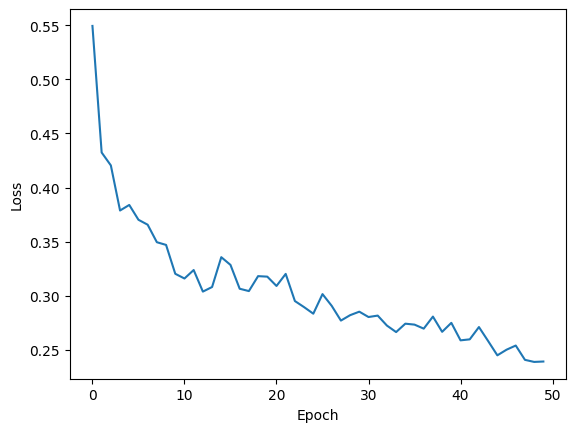

In [ ]:
plt.plot(loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [ ]:
y_pred = []
y_true = []
def accuracy(model, testloader, dataset_name):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to('cuda')
            labels = labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.append(predicted.to('cpu'))
            y_true.append(labels.to('cpu'))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network for {dataset_name} is: %d %%' % (
            100 * correct / total))

In [ ]:
accuracy(model, test_loader, 'Model ViT')

Accuracy of the network for Model ViT is: 87 %


In [ ]:
y_pred_list = []
y_true_list = []
for i in [a.squeeze().tolist() for a in y_pred]:
  for j in i:
    y_pred_list.append(j)

for i in [a.squeeze().tolist() for a in y_true]:
  for j in i:
    y_true_list.append(j)

In [ ]:
from sklearn import metrics
import seaborn as sns

In [ ]:
print("Overall accuracy: ",round(metrics.accuracy_score(y_true_list, y_pred_list),2))
print("Overall precision: ",round(metrics.precision_score(y_true_list, y_pred_list),2))
print("Overall recall: ",round(metrics.recall_score(y_true_list, y_pred_list),2))

Overall accuracy:  0.87
Overall precision:  0.88
Overall recall:  0.85


<Axes: >

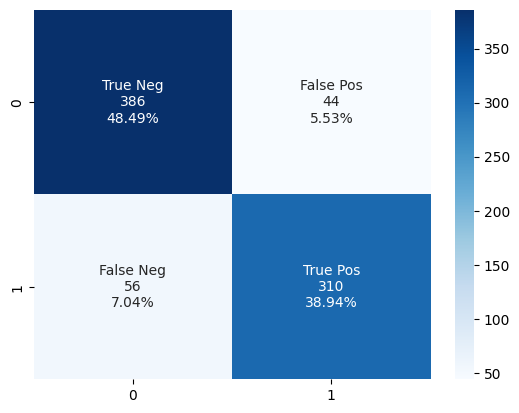

In [ ]:
cf_matrix = metrics.confusion_matrix(y_true_list, y_pred_list)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
import pandas as pd
cm = metrics.confusion_matrix(y_true_list, y_pred_list)
result_cls0 = []
result_cls1 = []
precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_true_list, y_pred_list)
result_cls0.append(round(cm[0][0] / (cm[0][0] + cm[0][1]), 2))
result_cls1.append(round(cm[1][1] / (cm[1][0] + cm[1][1]), 2))
result_cls0.append(round(cm[0][1] / (cm[0][0] + cm[0][1]), 2))
result_cls1.append(round(cm[1][0] / (cm[1][0] + cm[1][1]), 2))
result_cls0.append(round(precision[0], 2))
result_cls1.append(round(precision[1], 2))
result_cls0.append(round(recall[0], 2))
result_cls1.append(round(recall[1], 2))
result_cls0.append(round(fscore[0], 2))
result_cls1.append(round(fscore[1], 2))
roc0 = metrics.roc_auc_score(y_true_list, y_pred_list, labels=0)
roc1 = metrics.roc_auc_score(y_true_list, y_pred_list, labels=1)
result_cls0.append(round(roc0, 2))
result_cls1.append(round(roc1, 2))
mcc = metrics.matthews_corrcoef(y_true_list, y_pred_list)
result_cls0.append(round(mcc, 2))
result_cls1.append(round(mcc, 2))

df = pd.DataFrame([result_cls0, result_cls1],
  columns=['TPR', 'FPR', 'Precision', 'Recall', 'F-Measure', 'ROC', 'MCC'])

In [ ]:
print(df)

    TPR   FPR  Precision  Recall  F-Measure   ROC   MCC
0  0.90  0.10       0.87    0.90       0.89  0.87  0.75
1  0.85  0.15       0.88    0.85       0.86  0.87  0.75
